Imports

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import gradio as gr



In [119]:
df = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Finner alle verdiene som er numeriske

In [120]:
def ifNumeric(df): 
    numeric_columns = []
    for column in df.columns:
        if df[column].dtype.kind in 'biufc':
            numeric_columns.append(column)

    return numeric_columns

Tar alle de numeriske verdiene og finner outlierene og grafer disse

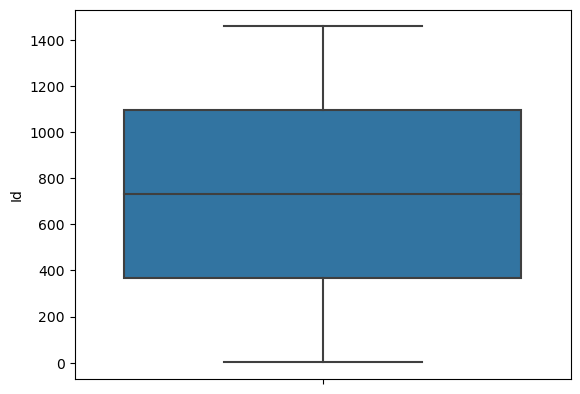

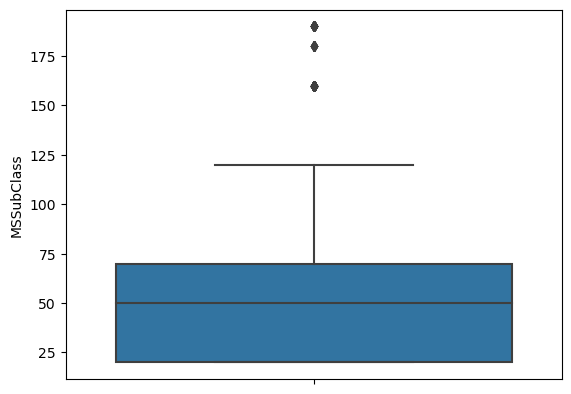

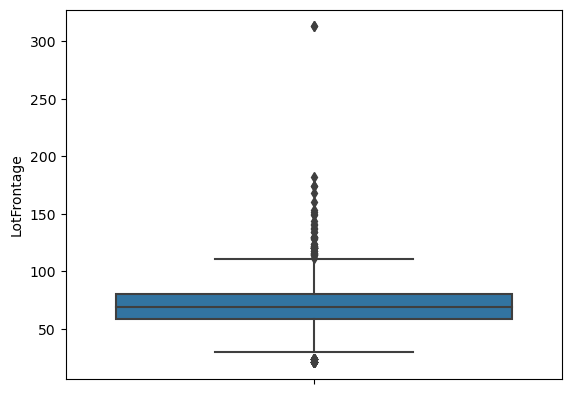

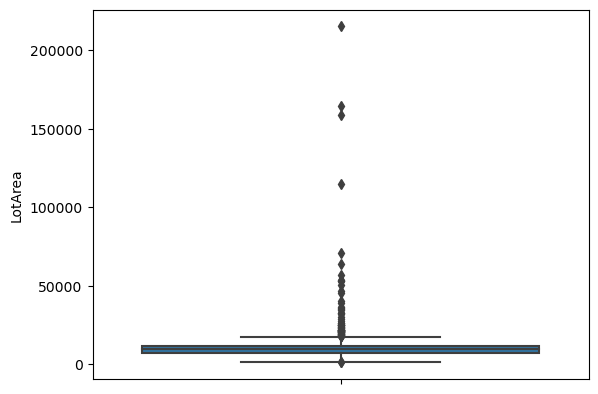

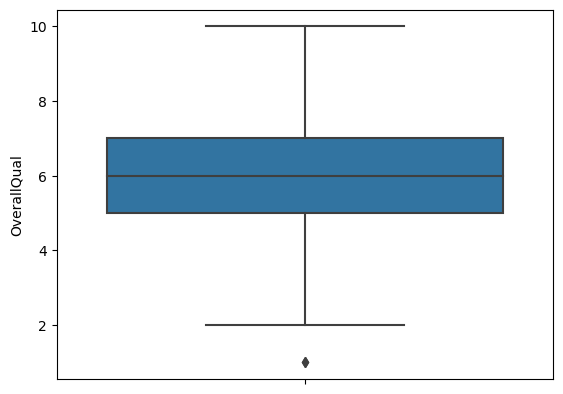

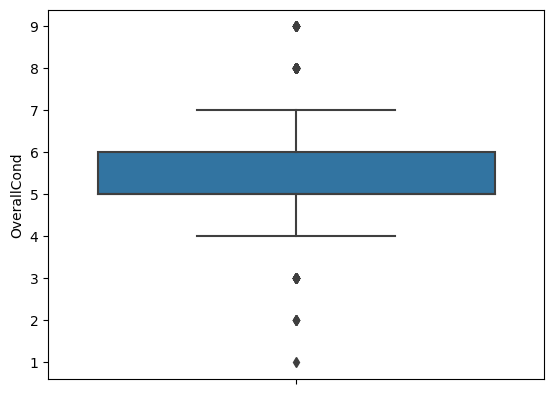

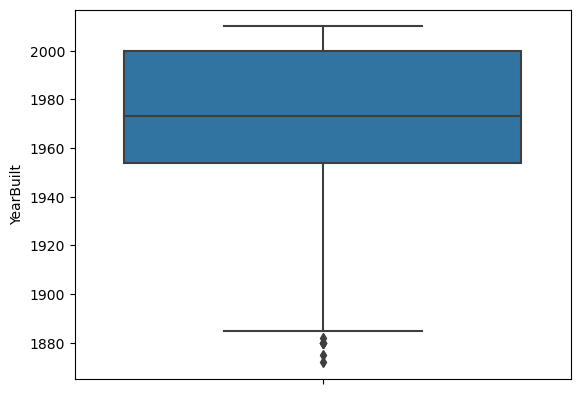

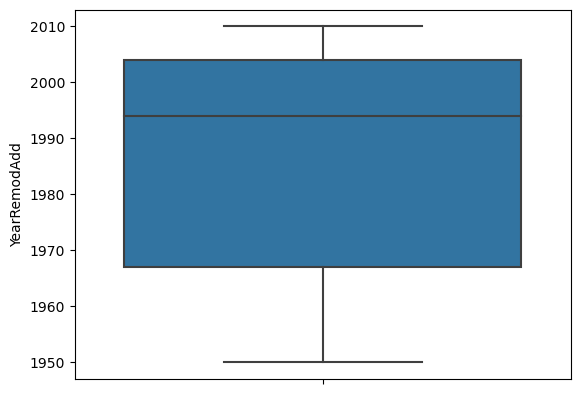

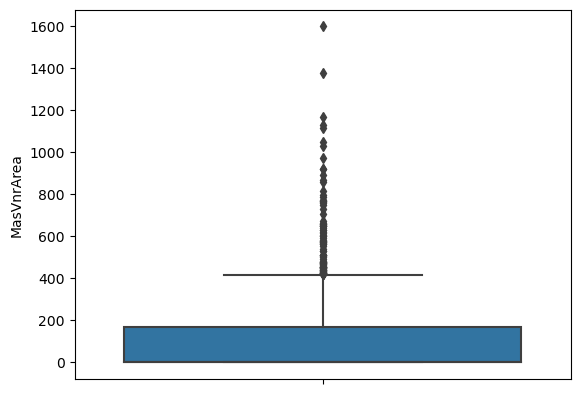

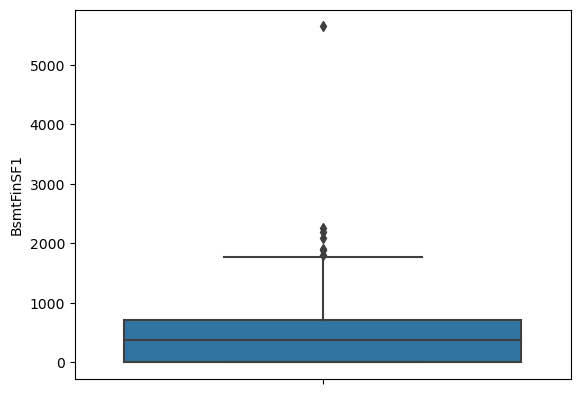

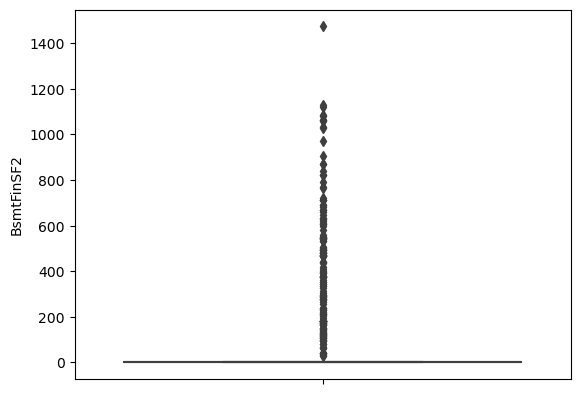

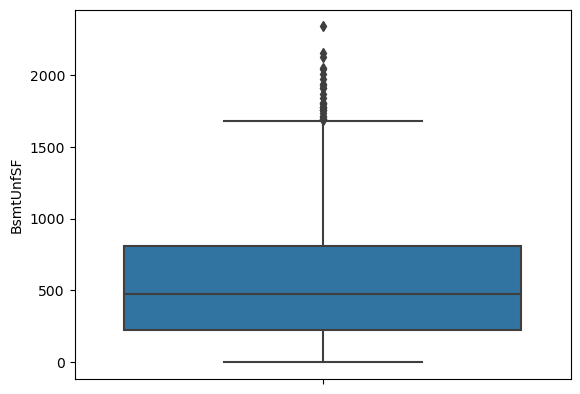

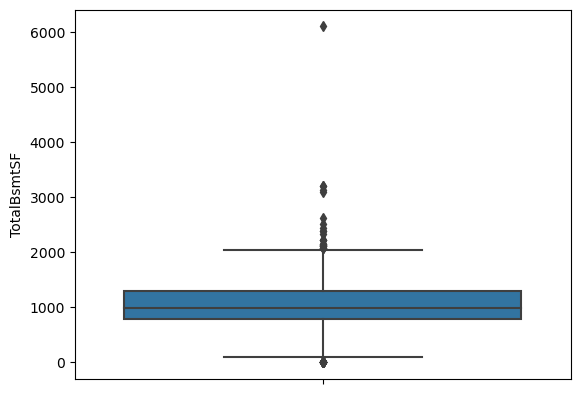

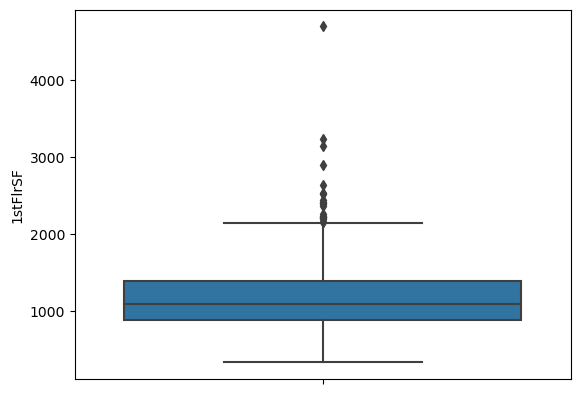

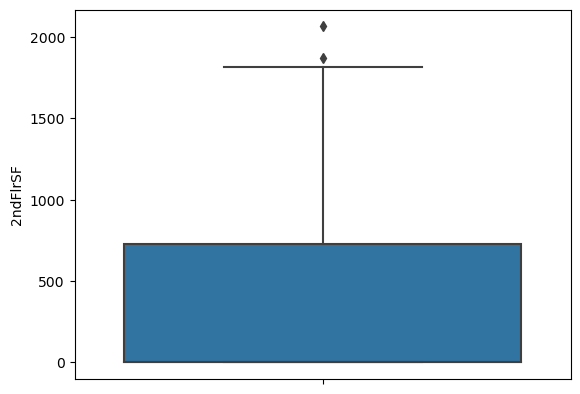

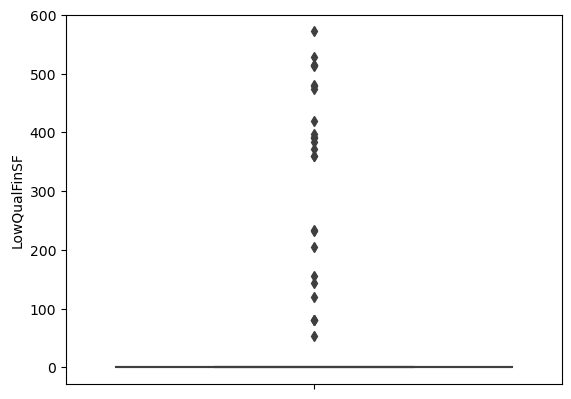

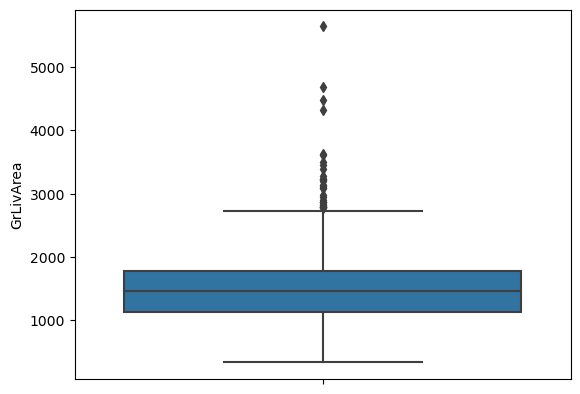

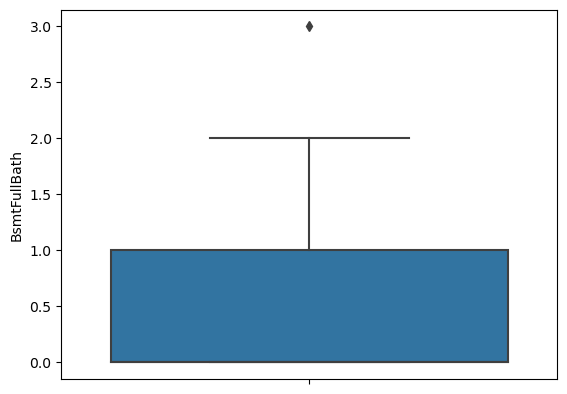

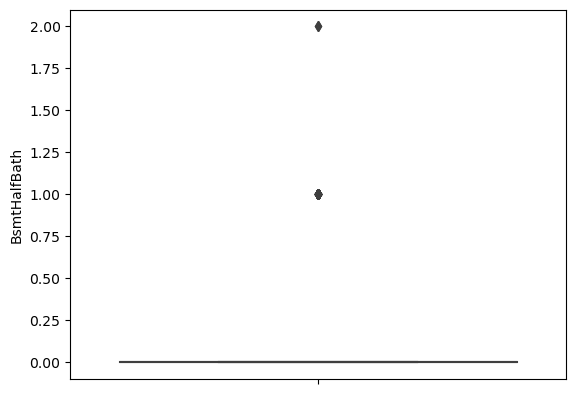

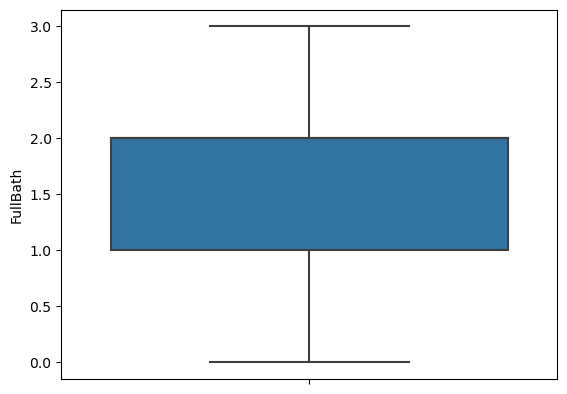

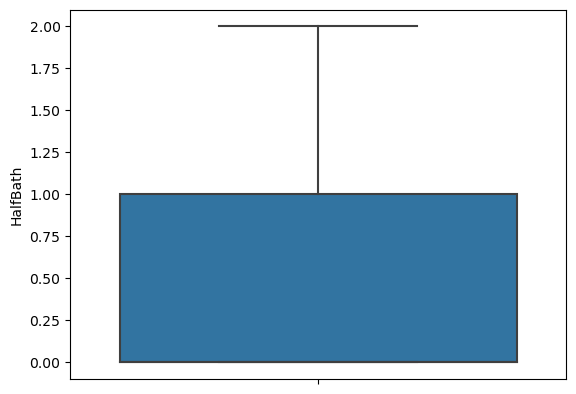

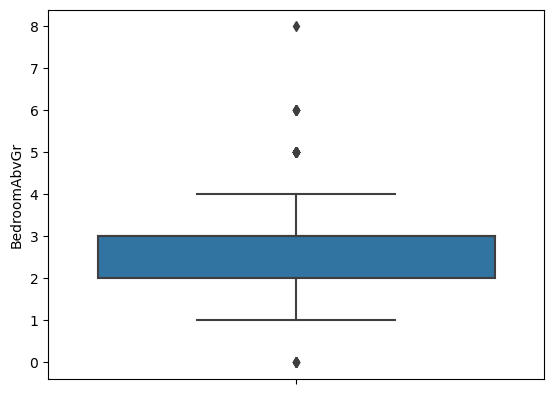

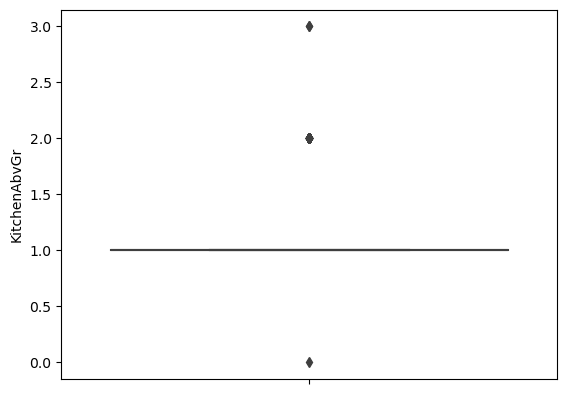

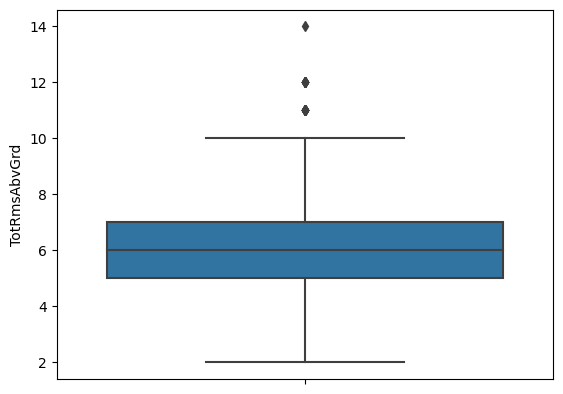

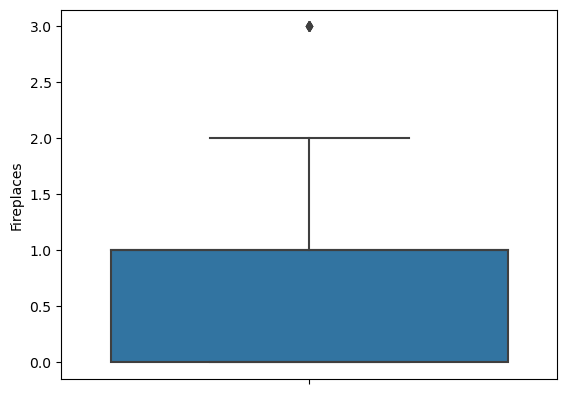

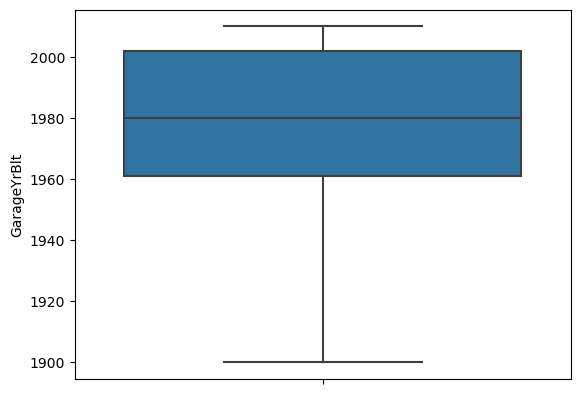

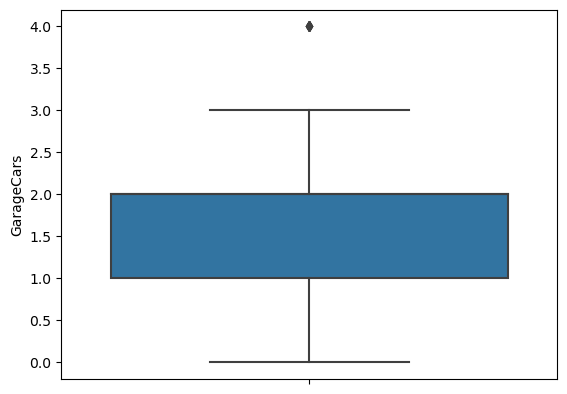

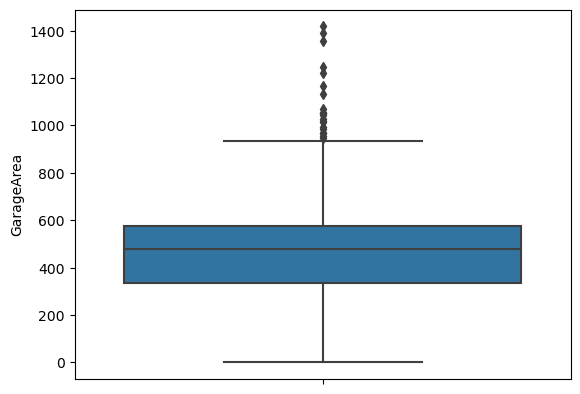

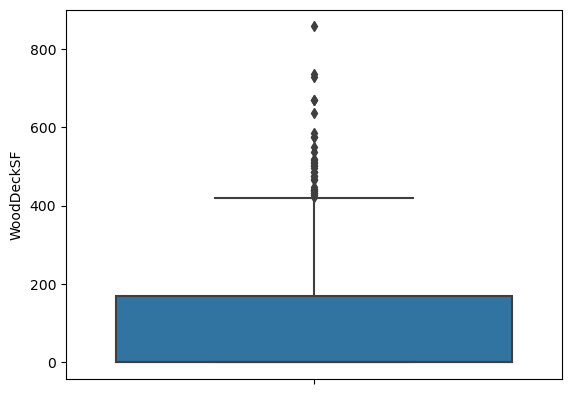

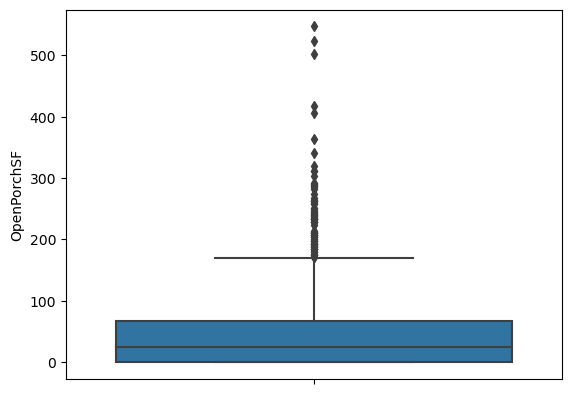

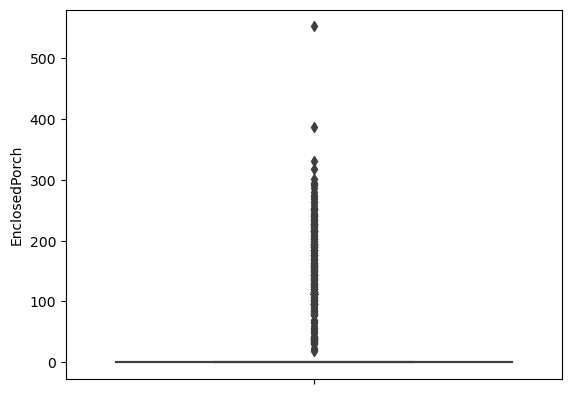

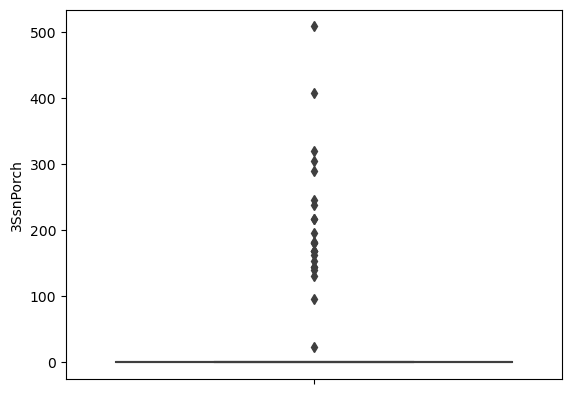

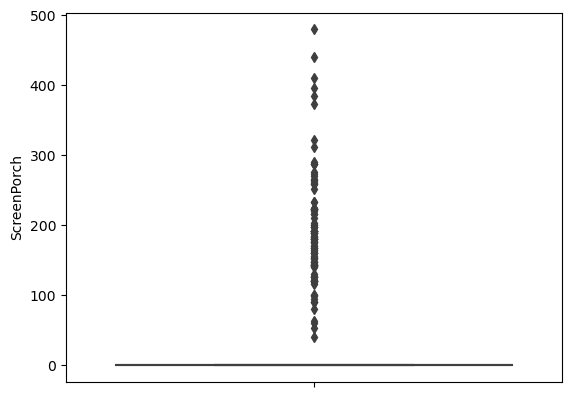

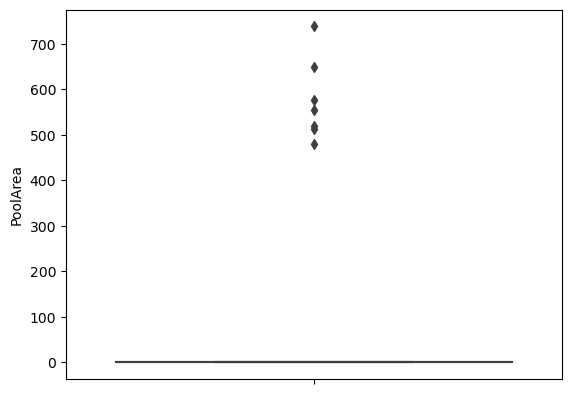

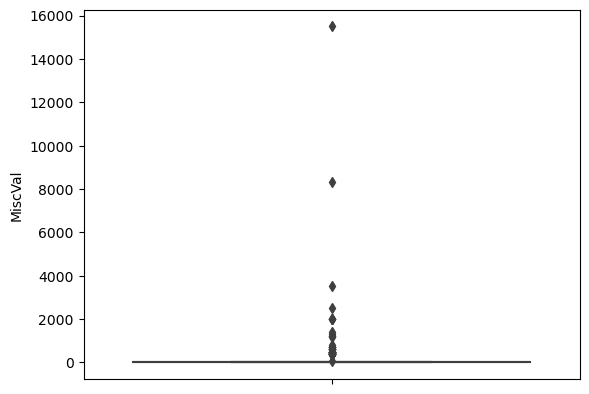

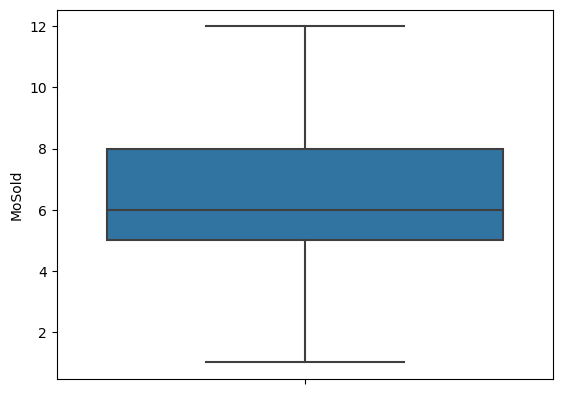

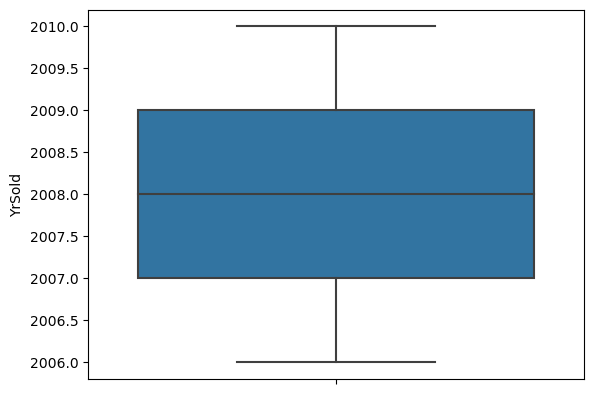

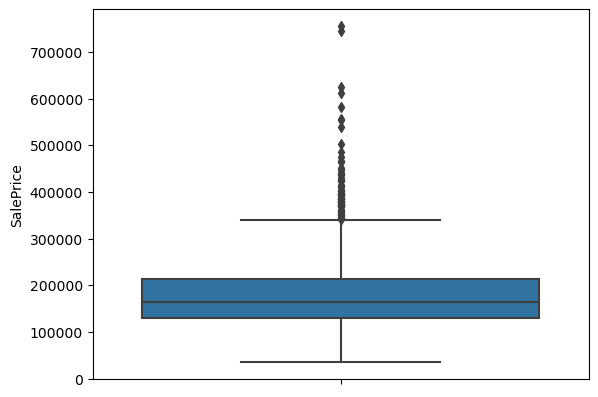

In [121]:
numerics = ifNumeric(df)


def checkOutliers(df, columns):
    for column in columns:
        plots = sns.boxplot(y=df[column])
        plt.show(plots)


plots = checkOutliers(df, df[numerics])

Fjerner alle outliers

In [122]:
def removeOutliers(df, columns): 
    for column in columns: 
        highpercent = df[column].quantile(0.98)
        df = df[(df[column] < highpercent)]

        return df
    
#df['BedroomAbvGr'] = df['BedroomAbvGr'].drop(outliers_to_be_dropped)

In [123]:
df = removeOutliers(df, ['MSSubClass', 'OverallCond', 'BsmtFinSF1',
	'TotalBsmtSF', '2ndFlrSF', 'BsmtFullBath',
	'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
	'GarageCars'])

Sjekker dataene for å se hva som kan one-hot-encodes og hva som ikke kan

Sjekker korrelasjon. Ser at det er en del verdier som er rundt 0.2 som sier at det ikke er sikkert den verdien vil gå opp hvis den andre verdier går opp.  

Gjør one-hot-encoding på alle verdier med object

In [124]:
def encodesomething(train_data, test_data, columns_to_drop):  
    
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()
    
    for i in columns_to_drop:
        train_data_copy = pd.get_dummies(train_data_copy, columns=[i], prefix=i)


        if i in test_data_copy: 
            test_data_copy = pd.get_dummies(test_data_copy, columns=[i], prefix=i)
            train_data_copy, test_data_copy = train_data_copy.align(test_data_copy, join='left', axis=1, fill_value=0)
    return train_data_copy, test_data_copy

all_one_hots = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope','Condition1', 'Condition2'
                , 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
                'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
                'Fence', 'MiscFeature', 'SaleType', 'SaleCondition','Street', 'Alley', 'Utilities', 'Neighborhood', 'RoofMatl'
                ]
df, test_data = encodesomething(df, test_data, all_one_hots)


In [125]:
#df = df.drop(columns=[], axis=1)
#df = df.drop(columns=['Street', 'Alley', 'Utilities', 'Neighborhood', 'RoofMatl', 'BedroomAbvGr', ], axis=1)
#test_data = test_data.drop(columns=['Street', 'Alley', 'Utilities', 'Neighborhood', 'RoofMatl'], axis=1)

Dropper verdier med null

In [126]:
df = df.dropna()
df = df.drop("Id", axis=1)

Sjekker korrelasjon for å finne ut hvilke data jeg kan droppe uten at det har særlig verdi. Fikk ikke noe særlig uttelling av dette derav er det kommentert ut. 

In [127]:
#def checkCorrelation(train_data, test_data, min_corr=-0.2, max_corr=0.2): 
#    corr_matrix = train_data.corr()
#    saleprice_corr = corr_matrix['SalePrice'].drop('SalePrice')
#
#    filtered_cols = saleprice_corr[(saleprice_corr >= min_corr) & (saleprice_corr <= max_corr)].index.tolist()
#
#    train_data = train_data.drop(columns=filtered_cols, axis=1)
#    test_data = test_data.drop(columns=filtered_cols, axis=1)
#
#    return train_data, test_data, filtered_cols
#
#df,test_data, filtered_columns = checkCorrelation(df, test_data, min_corr=-0.2, max_corr=0.2)


Setter labels

In [128]:
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

Plotter for å sjekke hvordan modellen treffer på prediction, kan teste flere modeller også å se hva som treffer mest

In [130]:
gb = GradientBoostingRegressor(n_estimators=500, max_depth=4, learning_rate=0.2)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

32171.636003427597

In [131]:
r2_score(y_test, y_pred)

0.8766162252915868

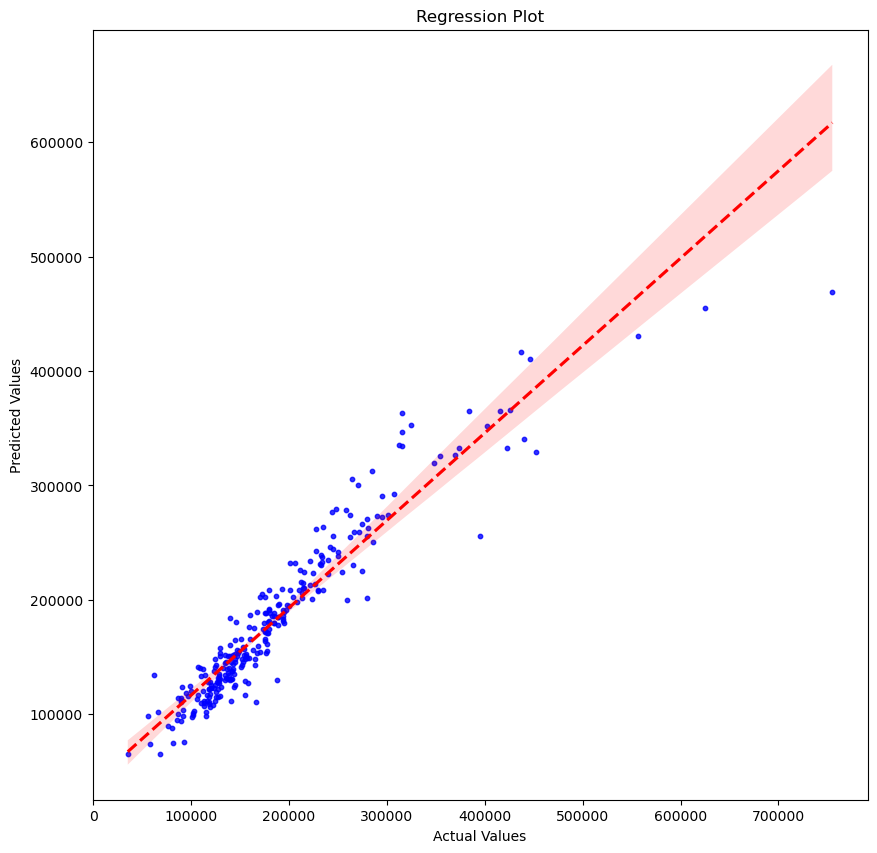

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red', 'linestyle': '--'})
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Regression Plot')
plt.show()

Lager Gradio applikasjon, men benytter meg kun av de numeriske verdiene da de andre er one-hot encoded og vanskelig å kontrollere. Setter de andre til mean value

In [133]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 0 to 1459
Columns: 287 entries, MSSubClass to RoofMatl_WdShngl
dtypes: float64(3), int64(33), uint8(251)
memory usage: 588.7 KB


In [134]:
df_floats = X.select_dtypes(include=[np.float64])
df_ints = X.select_dtypes(include=[np.int64])

In [135]:
pd.set_option('display.max_columns', None)

df_ints.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008


In [136]:
X = X.dropna()

Sjekker hvilke 10 som har mest korrelasjon for å vite hvilke jeg trenger i gradio 

In [137]:
variablestoconsider = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'MSSubClass', 'LotArea', 
                       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
                       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 
                       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 
                       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


variablesdf = df[variablestoconsider]

correlation_matrix = variablesdf.corr()

salepricecorr = correlation_matrix['SalePrice'].sort_values(ascending=False)

highestcorrelated = salepricecorr[1:11]

print(highestcorrelated)



OverallQual     0.797904
GrLivArea       0.714708
GarageCars      0.648323
GarageArea      0.620472
TotalBsmtSF     0.615368
FullBath        0.571353
TotRmsAbvGrd    0.561688
YearBuilt       0.523045
YearRemodAdd    0.517005
GarageYrBlt     0.501624
Name: SalePrice, dtype: float64


In [138]:
df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Utilities_AllPub,Utilities_NoSeWa,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawf

In [152]:
#Fikk deler av denne snutten av medstudenter slik at jeg fikk det til skikkelig

def predictSalePrice(MSSubClass, LotFrontage, LotArea, OverallQual, YearBuilt, YearRemodAdd, GrLivArea, TotRmsAbvGrd, GarageYrBlt, YrSold):
    df = X
    user_defined_columns = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", "YearBuilt", "YearRemodAdd", "GrLivArea", "TotRmsAbvGrd", "GarageYrBlt", "YrSold"]

    #Beregner mean-verdi
    mean_values = [col for col in df.columns if col not in user_defined_columns]        
    input_df = X.copy()
    
    input_df["MSSubClass"] = MSSubClass
    input_df["LotFrontage"] = LotFrontage
    input_df["LotArea"] = LotArea
    input_df["OverallQual"] = OverallQual
    input_df["GrLivArea"] = GrLivArea
    input_df["YearRemodAdd"] = YearRemodAdd
    input_df["TotRmsAbvGrd"] = TotRmsAbvGrd
    input_df["GarageYrBlt"] = GarageYrBlt
    input_df["YrSold"] = YrSold
    input_df["YearBuilt"] = YearBuilt
    
    for column in mean_values:
        if input_df[column].dtype == 'O':  
            mode_value = df[column].mode().iloc[0]
            input_df[column] = mode_value
        else:  # Numerisk kolonne
            mean_value = df[column].mean()
            input_df[column] = mean_value

    prediction = gb.predict(input_df)

    return prediction[0]

Finner max, min og mean verdi så jeg vet hva jeg skal putte i sliders

In [110]:
def findMinAndMax(df, label): 

    max = df[label].max()
    min = df[label].min()
    mean = df[label].mean()

    text =  "Min er: ", min,"Maxen er: ", max, "Mean er: ", mean
    return text


In [153]:
interface = gr.Interface(fn = predictSalePrice, inputs= [
    gr.components.Slider(minimum=20, maximum=180, value=53, label="MSSubClass"),
    gr.components.Slider(minimum=21, maximum=313, value=70, label="LotFrontage"),
    gr.components.Slider(minimum=1300, maximum=215245, value=10099, label="LotArea"),
    gr.components.Slider(minimum=2, maximum=10, value=6, label="OverallQual"),
    gr.components.Slider(minimum=1880, maximum=2010, value=1973, label="YearBuilt"),
    gr.components.Slider(minimum=1950, maximum=2010, value=1986, label="YearRemodAdd"),
    gr.components.Slider(minimum=438, maximum=5642, value=1530, label="GrLivArea"),
    gr.components.Slider(minimum=3, maximum=12, value=6, label="TotRmsAbvGrd"),
    gr.components.Slider(minimum=1906, maximum=2010, value=1978, label="GarageYrBlt"),
    gr.components.Slider(minimum=2006, maximum=2010, value=2007, label="YrSold")

],
outputs = gr.components.Textbox(label="Prediction"),
title="Predicting sale price",
description="Sale price predictor",
)

interface.launch()

Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


Tester noen regression teknikker for å se om det forbedrer resultatet noe

In [244]:
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(random_state = 42)
rf_reg.fit(X_train, y_train)

mean_squared_error(y_test, rf_reg.predict(X_test), squared=False)






33134.386606018896

ElasticNet

In [243]:
from sklearn.linear_model import ElasticNet


en = ElasticNet()
en.fit(X_train, y_train)
mean_squared_error(y_test, en.predict(X_test), squared=False)



c:\Users\Fredrik\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.592e+11, tolerance: 5.322e+08
  model = cd_fast.enet_coordinate_descent(


36190.6150853865

LinearRegression

In [245]:
from sklearn.linear_model import LinearRegression



lr = LinearRegression()
lr.fit(X_train, y_train) 
mean_squared_error(y_test, lr.predict(X_test), squared=False)



30172.43423785493

Parameter tuning. Ser at jeg ikke får noe særlig endringer etter hvilke modeller jeg velger, så nå tester jeg litt hyperparameter boosting på GB regressoren

In [202]:
from sklearn.model_selection import GridSearchCV, KFold

crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=crossvalidation)
search.fit(X_train,y_train)
search.best_params_

Sjekker hvordan GB boosting treffer

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'red', 'linestyle': '--'})
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Regression Plot')
plt.show()